In [24]:
'''This script demonstrates VAE on Rubik's cube image data sampled from Gazebo

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
 - Joint Multi-Modal VAE
   https://arxiv.org/pdf/1611.01891.pdf
'''
import warnings
import csv
import os
from glob import glob
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
plt.rcParams["figure.figsize"] = [20,20]
from scipy.stats import norm
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
import keras
from skimage.transform import resize
from PIL import Image

import sys, os
sys.path.append(os.path.expanduser('/opt/repositories/twbserver_notebook/notebook/tools'))
import vae_tools
from vae_tools import plot_model, layers, nb_tools, viz, loader, build_model, sanity, sampling, custom_variational_layer

nb_tools.notebook_resize()
sanity.check()

num_data = 1710
data_dir = 'img_0'

python version:  3.5.2
keras version: 2.2.4
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


In [25]:
# Read the poses and observations
with open(data_dir + "/lookup_pitch_yaw.csv", "r") as f:
    reader = csv.reader(f, delimiter=',')
    pose_pitch_yaw = np.asarray([[float(x[0]), float(x[1])] for x in list(reader)[1:]])
    f.close()

def get_iterator(batch_size):
    from keras.preprocessing.image import ImageDataGenerator
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0)  # randomly shift images vertically (fraction of total height))

    train_generator = train_datagen.flow_from_directory(data_dir, interpolation='nearest',
            color_mode='rgb', shuffle=False, seed=None,
            target_size=(60, 80),
            batch_size=batch_size,
            #save_to_dir='img_0_augmented',
            class_mode=None)
    return train_generator
X_train = get_iterator(num_data).next()

Found 1710 images belonging to 1 classes.


Found 1710 images belonging to 1 classes.
(60, 80, 3)


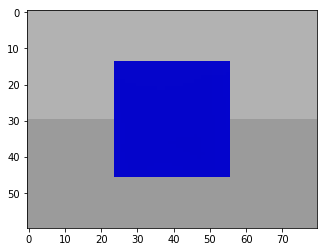

In [3]:
# Show some scaled image
x = get_iterator(1).next()
print(x[0].shape)
plt.imshow(x[0])
plt.show()

In [4]:
# input image dimensions and config
use_conv = False
batch_size = 128
image_rows_cols_chns = (60, 80, 3)
original_dim = np.prod(image_rows_cols_chns)
latent_dim = 2
intermediate_dim = 256 # former 128
intermediate_dim_2 = int(intermediate_dim / 2)
epochs = 4000
save_model = False
#beta = 0.012207031 # 50.
beta = 1.

if use_conv:
    # number of convolutional filters to use
    filters = 32 # former 64
    # convolution kernel size
    num_conv = 3
    # Other values
    rows = image_rows_cols_chns[0]
    rows_2 = int(rows/2)
    cols = image_rows_cols_chns[1]
    cols_2 = int(cols/2)
    img_chns = image_rows_cols_chns[2]
    if keras.backend.image_data_format() == 'channels_first':
        original_img_size = (image_rows_cols_chns[2], image_rows_cols_chns[0], image_rows_cols_chns[1])
        output_shape_reshape = (batch_size, filters, rows_2, cols_2)
        output_shape_upsamp = (batch_size, filters, rows+1, cols+1)
    else:
        original_img_size = image_rows_cols_chns
        output_shape_reshape = (batch_size, rows_2, cols_2, filters)
        output_shape_upsamp = (batch_size, rows+1, cols+1, filters)
else:
    # Reshape the data
    X_train = X_train.reshape(len(X_train),np.prod(X_train.shape[1:]))

if use_conv:
    encoder = [[
        Input(shape=original_img_size),
        Conv2D(img_chns, kernel_size=(2, 2), padding='same', activation='relu'),
        Conv2D(filters, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2)),
        Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1),
        Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1),
        Flatten(),
        Dense(intermediate_dim, activation='relu')
    ]]
    
    decoder = [[
        Dense(intermediate_dim, activation='relu'),
        Dense(filters * rows_2 * cols_2, activation='relu'),
        Reshape(output_shape_reshape[1:]),
        Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu'),
        Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu'),
        Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu'),
        Conv2D(img_chns, kernel_size=2, padding='valid', activation='sigmoid')
    ]]

else:
    encoder = [[
        Input(shape=(original_dim,)),
        Dense(intermediate_dim, activation='relu'),
        Dense(intermediate_dim_2, activation='relu')
    ]]
    
    decoder = [[
        Dense(intermediate_dim_2, activation='relu'),
        Dense(intermediate_dim, activation='relu'),
        Dense(original_dim, activation='sigmoid')
    ]]
    

Store model to filename: tmp/myVAE.png and tmp/myVAE.svg
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14400)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          3686656     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            258         dense_2[0][0]                    
____________________________________________________

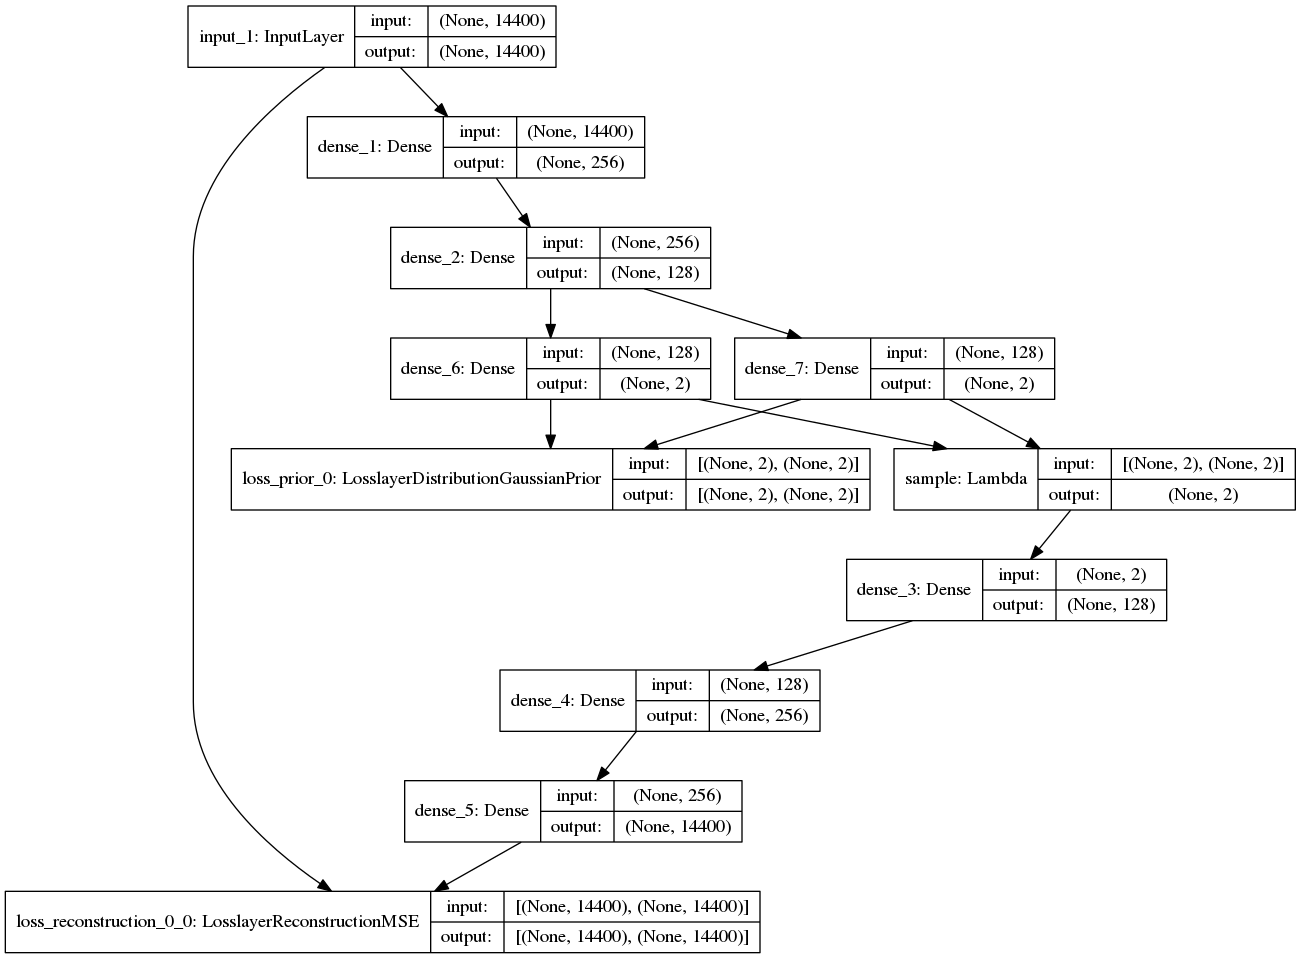

In [5]:
model_obj = vae_tools.mmvae.MmVae(latent_dim, encoder, decoder, [original_dim], beta, beta_is_normalized = False, reconstruction_loss_metrics = [vae_tools.mmvae.ReconstructionLoss.MSE], name='Vae')
vae = model_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [6]:
# Show some examples
#viz.random_images_from_set(X_set, image_rows_cols_chns, n = 15);

In [7]:
# Train
vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose = 0)


In [8]:
# Store the model
if use_conv:
    model_obj.store_model("cameraRGB_conv_encoder_mean", model = model_obj.get_encoder_mean([encoder[0][0]]), overwrite = save_model)
else:
    model_obj.store_model("cameraRGB_encoder_mean", model = model_obj.get_encoder_mean([encoder[0][0]]), overwrite = save_model)

Saved model cameraRGB_encoder_mean to disk
Saved weights of model cameraRGB_encoder_mean to disk


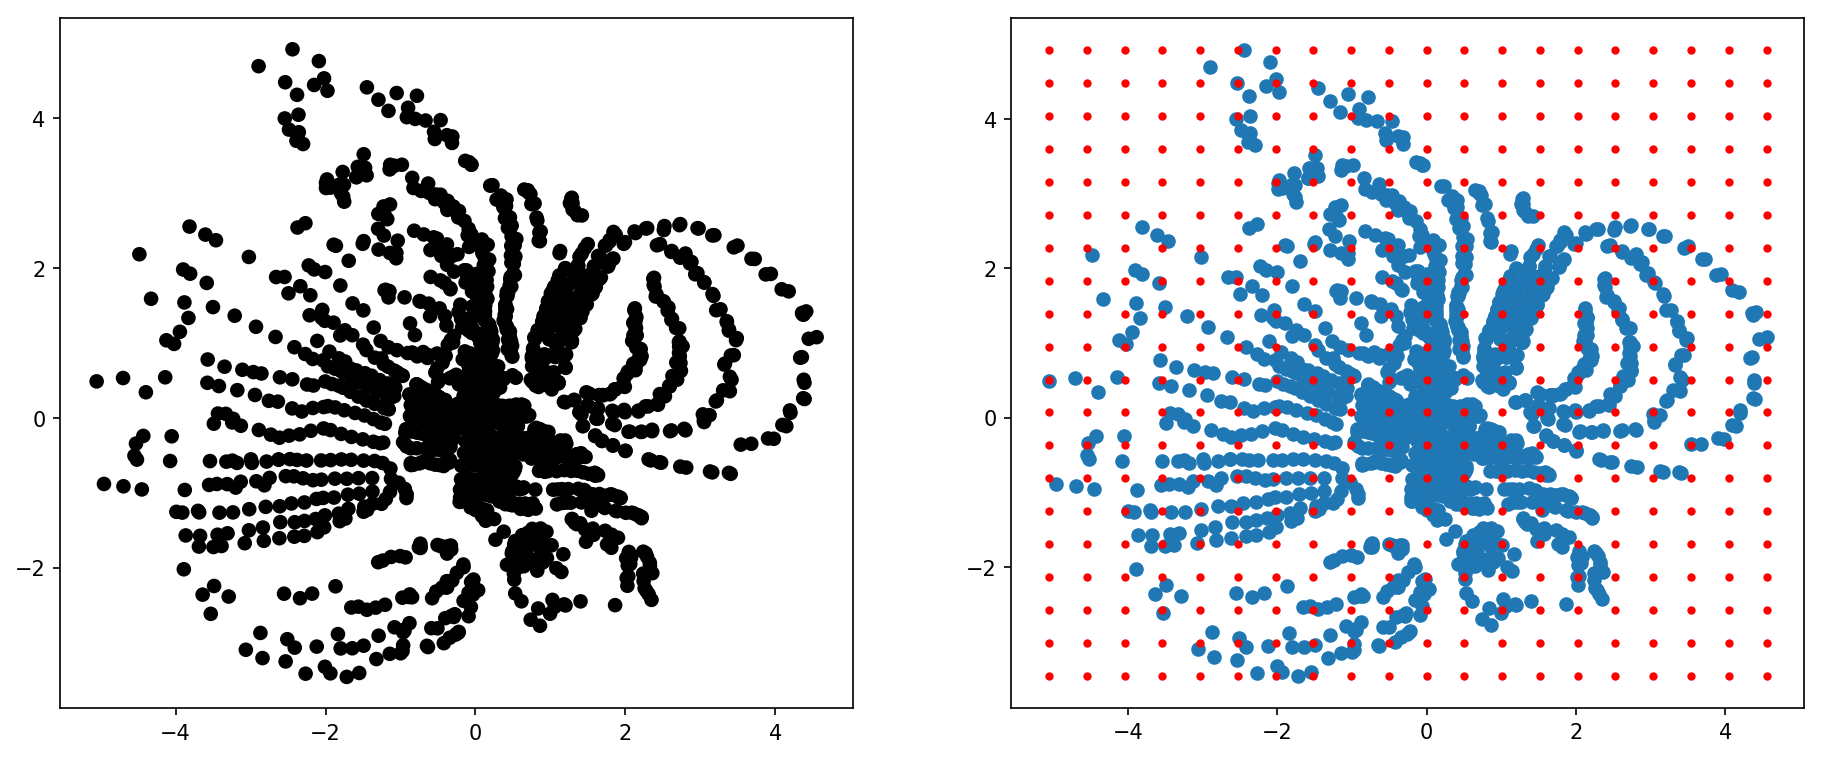

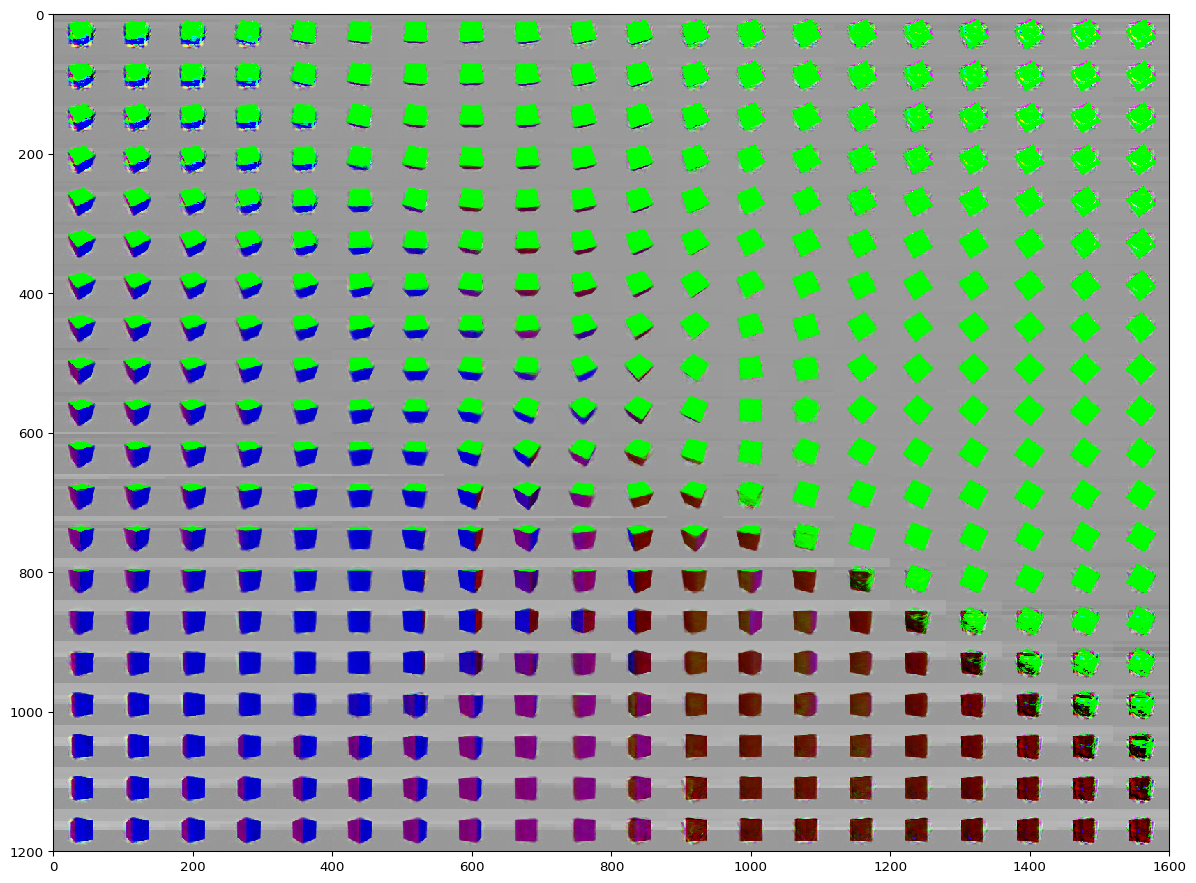

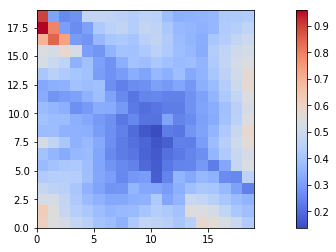

In [9]:
import vae_tools
from importlib import reload
reload(vae_tools)

# Vizualization
# Encode samples to get the min and max values in latent space
x_test_encoded = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train, batch_size=batch_size)

# display a 2D manifold
nx = 20
ny = 20

## linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
## to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.001, 0.999, nx))
grid_y = norm.ppf(np.linspace(0.001, 0.999, ny))
grid_x = np.linspace(np.amin(grid_x), np.amax(grid_x), nx)
grid_y = np.linspace(np.amin(grid_y), np.amax(grid_y), ny)
grid_x = np.linspace(np.amin(x_test_encoded[:, 0]), np.amax(x_test_encoded[:, 0]), nx)
grid_y = np.linspace(np.amin(x_test_encoded[:, 1]), np.amax(x_test_encoded[:, 1]), ny)

# display a 2D plot of the digit classes in the latent space
import vae_tools
from importlib import reload  # Python 3.4+ only.
viz = reload(vae_tools.viz)
vae_tools.viz.scatter_encoder(X_train, np.zeros((len(X_train),3)), grid_x, grid_y, model_obj, figsize=(15, 15), dpi=150)

# Plot the resampled inputs
figure, x_mean_test_encoded, x_std_test_encoded = viz.get_image_dec_enc_samples(grid_x, grid_y, model_obj, image_rows_cols_chns)
plt.figure(figsize=(15, 15), dpi=96)
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Plot the resampled std deviations
X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
plt.pcolor(X, Y, x_std_test_encoded, cmap='coolwarm', vmin=x_std_test_encoded.min(), vmax=x_std_test_encoded.max())
plt.colorbar()
plt.axis("image")
plt.show()

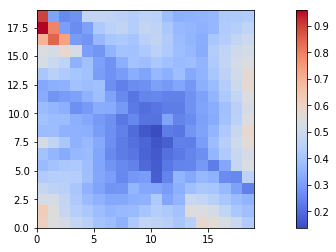

(20, 20)
(20, 20)


In [10]:
# Plot the resampled std deviations
X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
plt.pcolor(X, Y, x_std_test_encoded, cmap='coolwarm', vmin=x_std_test_encoded.min(), vmax=x_std_test_encoded.max())
plt.colorbar()
plt.axis("image")
plt.show()
print(X.shape)
print(x_std_test_encoded.shape)

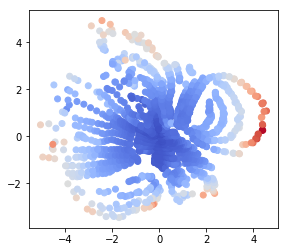

In [14]:
# Plot the resampled std deviations
#X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
x_encoded_logvar = model_obj.get_encoder_logvar([encoder[0][0]]).predict(X_train, batch_size=batch_size)
x_encoded_mean = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train, batch_size=batch_size)
#X, Y = np.meshgrid(x_encoded_mean[:,0], x_encoded_mean[:,1])
x_encoded_logvar_viz = np.sum(np.exp(x_encoded_logvar), axis = 1)
plt.scatter(x_encoded_mean[:,0], x_encoded_mean[:,1], c=x_encoded_logvar_viz, cmap='coolwarm', vmin=x_encoded_logvar_viz.min(), vmax=x_encoded_logvar_viz.max())
#plt.colorbar()
plt.axis("image")
plt.show()


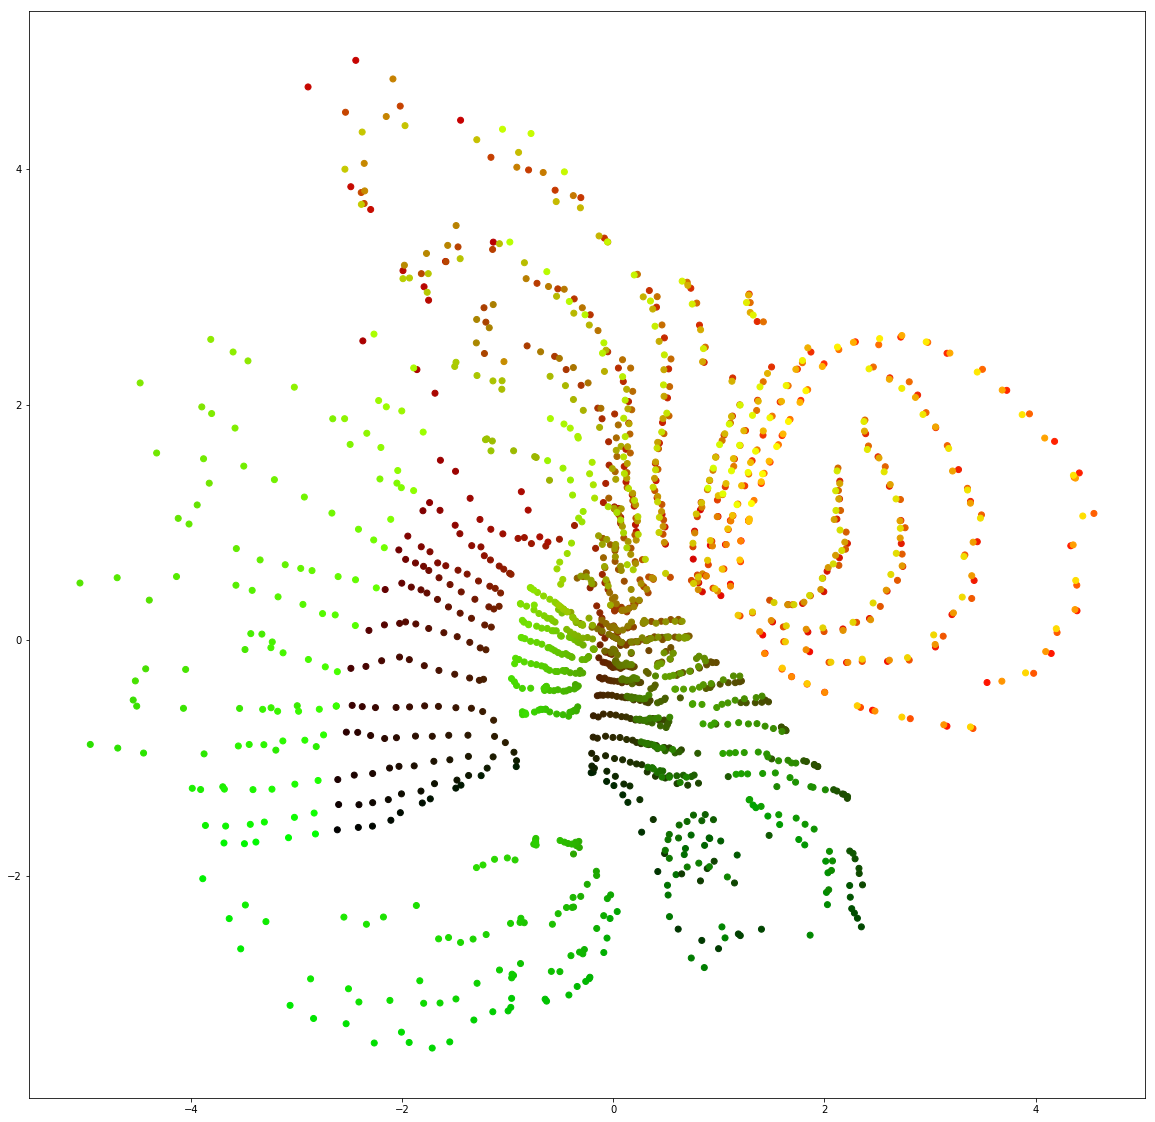

In [26]:
# Check the output distribution of the feature extractor
X_train_flatten = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:])))
X_train_feat = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_flatten)
c = np.concatenate(((pose_pitch_yaw - np.min(pose_pitch_yaw, axis=0)) / np.max(pose_pitch_yaw, axis=0), np.zeros((num_data,1))), axis=1)
plt.scatter(X_train_feat[:,0], X_train_feat[:,1], c=c)
plt.show()
